## Installing Libraries

If you don't have the following libraries, install them one by one first. 

In [ ]:
#pip install pytorch
#pip install torchvision
#pip install matplotlib

## Importing Libraries

If you are using PyCharm, you may encounter the following error: "MP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized." If this is the case, then in your imports add the following lines of code as well:
```
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
```

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F

## Loading Data

In [8]:
# Define a transform to normalize the data with colour
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Defining The ML Model

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward (self, x):
        x = x.view(x.shape[0], -1)   #Flatenning the input tensor

        x = self.dropout(F.relu(self.fc1(x)))      #relu activation for each hidden layer + dropout
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)       #Note: no dropout in final layer

        return x

## Training The ML Model

In [10]:
#With the model defined, call it.
model = Classifier()

# Define the loss
criterion = nn.NLLLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps= 0
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        logps = model(images)       #This is a faster way to run the forward pass.
        loss = criterion(logps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        # print(f"Training loss: {running_loss}")
        test_loss = 0
        accuracy = 0

        #Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()      #Makes dropout probability = 0. You don't want drop out during inference.
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()  # To go back to training with a dropout, use this function.

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
        "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
        "Test Loss: {:.3f}.. ".format(test_loss / len(testloader)),
        "Test Accuracy: {:.3f}.. ".format(accuracy / len(testloader)))


Epoch: 1/5..  Training Loss: 0.601..  Test Loss: 0.454..  Test Accuracy: 0.834.. 
Epoch: 2/5..  Training Loss: 0.486..  Test Loss: 0.439..  Test Accuracy: 0.842.. 
Epoch: 3/5..  Training Loss: 0.459..  Test Loss: 0.416..  Test Accuracy: 0.851.. 
Epoch: 4/5..  Training Loss: 0.429..  Test Loss: 0.403..  Test Accuracy: 0.854.. 
Epoch: 5/5..  Training Loss: 0.421..  Test Loss: 0.399..  Test Accuracy: 0.857.. 


## Creating A Function To Classify Data

In [11]:
def view_classify(img, ps, version="Fashion"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()     #Note, in pycharm you need to add plt.show() to view results.


## Classifying Data

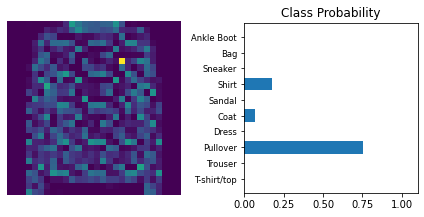

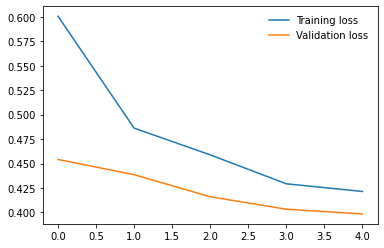

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model(img))
view_classify(img, ps, version='Fashion')

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()